So first we restore our variables that we stored in `nb1`.

In [90]:
%store -r

In [204]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell 
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [267]:
InteractiveShell.ast_node_interactivity = "all"
path = "../../csv/Mercedes-Benz Greener Manufacturing/"

So now we will try to find out which feature interactions are important from various importances that we calculated in `nb1`. 

In [30]:
var_df_ohe = pd.DataFrame(columns=['feature','variance'])
var_df_le = pd.DataFrame(columns=['feature','variance'])
for feat in tqdm(train_le.drop(['y','logy'], axis=1).columns):
    var_df_le.loc[var_df_le.shape[0],:] = list((feat, train_le[feat].var()))

for feat in tqdm(train_ohe.drop(['y','logy'], axis=1).columns):
    var_df_ohe.loc[var_df_ohe.shape[0],:] = list((feat, train_ohe[feat].var()))

var_df_ohe = var_df_ohe.sort_values(by='variance', axis=0).reset_index(drop=True)
var_df_le = var_df_le.sort_values(by='variance', axis=0).reset_index(drop=True)

100%|██████████| 507/507 [00:01<00:00, 309.58it/s]


Above we have calculated variance of each individual feature in both the encodings. This will help us in dropping features that have almost zero variance. From now on we will perform our analysis on one hot encoding and later we will check label encoding. 

Next we will try to find features which we can drop from our analysis

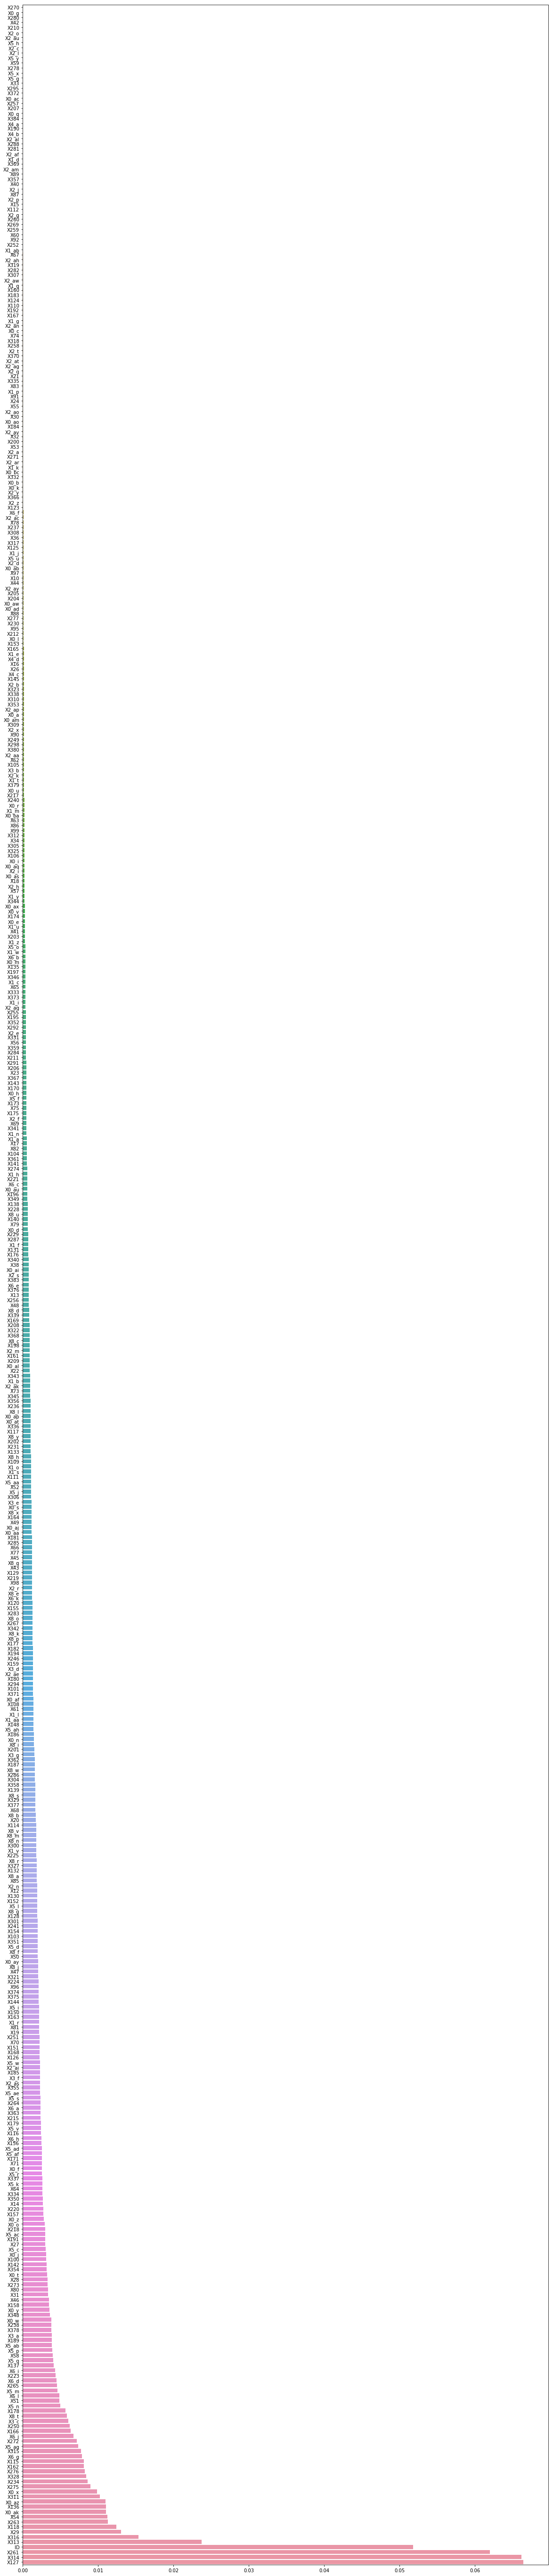

In [113]:
_,ax = plt.subplots(figsize=(20,100))
_=sns.barplot(x=list(feat_imp_ohe), y=list(feat_imp_ohe.index), ax=ax)


From above bar plot we can decide to drop features which have less importance. Let's add last 100 features to a list that we will drop. 

In [145]:
drop_feat_rf_ohe = []
drop_feat_rf_ohe.extend(list(feat_imp_ohe.index[:100]))

In [168]:
drop_feat_var_ohe = []
drop_feat_var_ohe.extend(list(var_df_ohe.iloc[:96].feature.values))

Here I have added those features to the list which have less than 10 ones in them and thus have a very low variance. 


In [180]:
drop_feat_anova = []
drop_feat_anova.extend(list(feat_imp_anova.loc[feat_imp_anova['p-value'] > 0.2, :].index))

Above we have added those features in removal list which have p-value > 0.2 which is quite a conservative p-value but it already covers more than 140 features. Let's now actually remove them one by one and see if we can get an improvement. 

First let's properly split our data into train and valid so that we get an honest estimate our test score. 

In [186]:
X_ohe = train_ohe.drop(['y','logy'], axis=1)
y = train_ohe['y']
X_ohe_train, X_ohe_val, y_train, y_val = train_test_split(X_ohe, y, test_size=0.25, random_state=random_state)

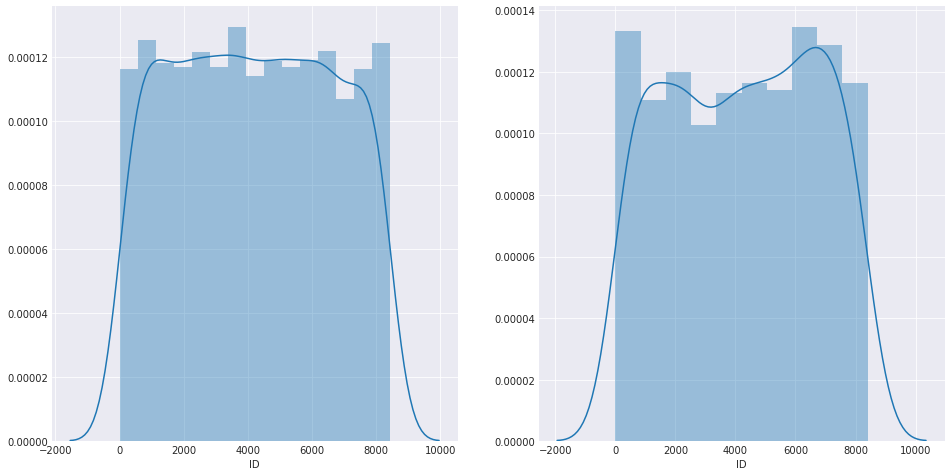

In [199]:
sns.set_style('darkgrid')
_,ax = plt.subplots(ncols=2, figsize=(16,8))
_=sns.distplot(X_ohe_train['ID'], ax=ax[0])
_=sns.distplot(X_ohe_val['ID'], ax=ax[1])

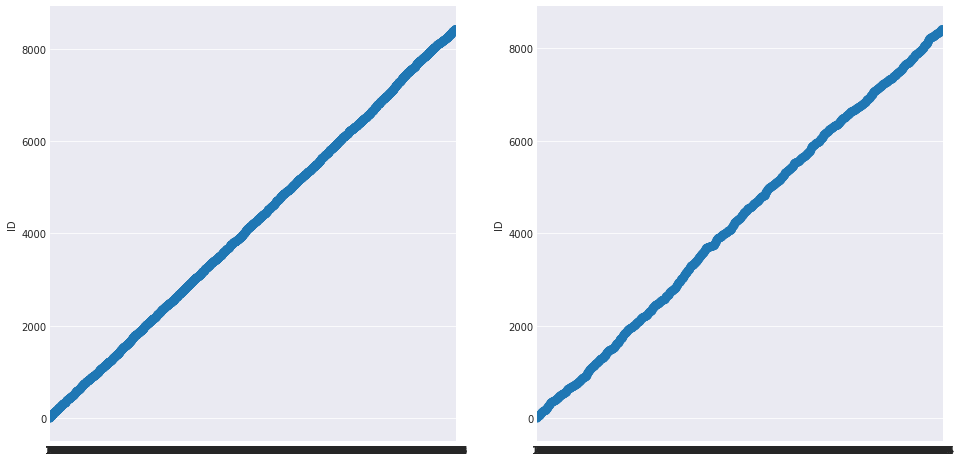

In [200]:
_,ax = plt.subplots(ncols=2, figsize=(16,8))
_=sns.pointplot(X_ohe_train.index.values, y=X_ohe_train.ID, ax=ax[0])
_=sns.pointplot(X_ohe_val.index.values, y=X_ohe_val.ID, ax=ax[1])

Here we can see that out train and validation have similar splitting as our train and test which we saw in last notebook.

In [214]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1)
_=rf.fit(X_ohe_train.drop(drop_feat_rf_ohe, axis=1), y_train)
y_pred = rf.predict(X_ohe_val.drop(drop_feat_rf_ohe, axis=1))

In [215]:
print (r2_score(y_val, y_pred))

0.57311178749


In [216]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1)
_=rf.fit(X_ohe_train.drop(drop_feat_anova, axis=1), y_train)
y_pred = rf.predict(X_ohe_val.drop(drop_feat_anova, axis=1))

In [217]:
print (r2_score(y_val, y_pred))

0.559634535168


In [218]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state+20, max_features='sqrt', n_jobs=-1)
_=rf.fit(X_ohe_train.drop(drop_feat_var_ohe, axis=1), y_train)
y_pred = rf.predict(X_ohe_val.drop(drop_feat_var_ohe, axis=1))

In [219]:
print (r2_score(y_val, y_pred))

0.573491707912


Now there seems to be some improvement in our `r2_score` by removing irrelevant features.So next we can try to merge the features in the 3 lists but first let's try to make a list of very important features from `feat_imp_ohe` so that we don't accidently drop any of the important feature. 


In [263]:
must_include_feat = list(feat_imp_ohe[-100:].index)
drop_feat = list(set(drop_feat_anova+drop_feat_rf_ohe+drop_feat_var_ohe))
drop_feat = [f for f in drop_feat if f not in must_include_feat]
len(drop_feat)

187

So overall we have shortlisted 187 features that we intend to drop from our model. Let's try random forest without these features. 

In [289]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state+11, max_features='sqrt', n_jobs=-1)
_=rf.fit(X_ohe_train.drop(drop_feat, axis=1), y_train)
y_pred = rf.predict(X_ohe_val.drop(drop_feat, axis=1))

In [290]:
print (r2_score(y_val, y_pred))

0.573217621328


Not much of improvement. :/ Anyway let's make a submission by training our model on full data. 

In [282]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1)
_=rf.fit(X_ohe.drop(drop_feat, axis=1), y)
y_pred = rf.predict(test_ohe.drop(drop_feat, axis=1))

In [288]:
subm = np.stack((test_ohe.ID.values, np.round(y_pred,5)), axis=1)
np.savetxt(path+'subm1.csv', subm, delimiter=',',header='ID,y', comments='', fmt=['%d','%.5f'])

The score on kaggle leaderboard is 0.537. Also if we train our random forest model on full data we have same r2 score on validation as we see in next cells. 

In [298]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1)
_=rf.fit(X_ohe_train.drop(drop_feat, axis=1), y_train)
y_pred = rf.predict(X_ohe_val.drop(drop_feat, axis=1))

In [299]:
print (r2_score(y_val, y_pred))

0.57222186395
